### MD Muhaimin Rahman
contact: sezan92@gmail.com


# Introduction

In this notebook, I am describing the implementation of Control Systems namely [PID](#pid_sec),[Fuzzy Logic](#fuzzy_sec) and [LQR](#lqr_sec) on our robot. The $pidcontrol.py$ file has been used for our project. I haven't written this library. I have downloaded from this github project.[1](#pid)

#### Importing Libraris

In [1]:
import sys
import pidcontrol as pid
import numpy as np
import pybullet as p
import math
import time
import pybullet_data
import control 
import scipy


# LQR Controller

Here, I am working on LQR controller. I have used control library [[3](#PythonControl)] of python to work on lqr. For the lqr controllers, the state-space equations of the system are required. For the Inverted pendulum , the equation will be the following
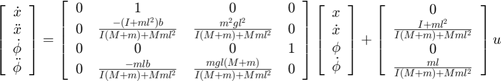

![system](LQR.png)

The above equation is derived from [[4](#SystemEquation)] .Here, $m$ mass of the pendulum, $I$ is mass moment of Inertia , $M$ mass of Cart, $g$ gravitational acceleration, $\phi$ yaw angle, $u$ is force and $x$ is the movement of the cart. we can simplify by writing , $\dot{x} = Ax+Bu $, where A and B in our robot will be the following

In [2]:
#(M)       mass of the cart                         0.5 kg
#(m)       mass of the pendulum                     0.2 kg
#(b)       coefficient of friction for cart         0.1 N/m/sec
#(l)       length to pendulum center of mass        0.3 m
#(I)       mass moment of inertia of the pendulum   0.006 kg.m^2
#(F)       force applied to the cart
#(x)       cart position coordinate
#(theta)   pendulum angle from vertical (down)
#x(t+1)=A*x(t)+B*u
#x(t+1)=k*x(t)

M = .5;
m = 0.2;
b = 0.1;
I = 0.006;
g = 9.8;
l = 0.3;

px = I*(M+m)+pow(M*m*l,2) #denominator for the A and B matrices

A = np.array([[0,1],[m*g*l*(M+m)/px,0]])#considering theta and theta dot
B = np.array([[  0.  ],
       [ m*l/px]])

From [[4](#SystemEquation)] , we get the cost function \begin{equation}
J = \int (x^TQx +u^TRu)dt
\end{equation}


Here, we need to tune Q matrix and R such that the value of $J$ is minimum.

Our topics for LQR

Here, we will tune the values of Q and R using /Q and /R topic respectively.

The class for LQR

In [3]:
Q = np.array([[ 100,   0],[  0, 1000]])
R = 0.0001
# K,S,e = lqr(A,B,Q,R)
# print(K)
# print(S)
# print(e)

In [4]:
class SelfBalanceLQR:
    def __init__(self):
        self.xvelMin=-.01# x velocity
        self.xvelMax =0
        self.yMin = -0.01#yaw
        self.yMax = 0
        self.y_ = 0
        self.Q = np.array([[ 100,   0],[  0, 1000]])
        self.R = 0.0001
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)
    def callback(self,data):
        
        vel = data[0][0]
        y = data[1][1]*180/3.1416#theata changes along 1
        
        diff_yaw = y-self.y_
        np_x = np.array([[y],[diff_yaw]])
        
        u_t=-np.matmul(self.K,np_x) 
        #print(np_x,self.K,u_t)
        #print(np_x.shape,self.K.shape,u_t.shape,A.shape,B.shape)
        xvel = (np.matmul(A,np_x)+np.matmul(B,u_t))[1]
        #print(xvel)
        
        if y>self.yMax:
            self.yMax = y
        elif y<self.yMin:
            self.yMin =y
        if xvel>self.xvelMax:
            self.xvelMax=xvel
        elif xvel<self.xvelMin:
            self.xvelMin = xvel
            
        linear_vel = [xvel,0,0]
        angular_vel=[0,0,0]
        #print("Max vel " + str(self.xvelMax) + " & Min vel " + str(self.xvelMin) + " Max y " + str(self.yMax*180/3.1416) +" & Min y" + str(self.yMin*180/3.1416))
        #print("Velocity "+ str(xvel)+ " & yaw " + str(y))
        self.y_ = y
        
        return xvel
        
    def callback_q(self,data):
        q = data.data
        self.Q = np.array([[ q,   0],[  0, 10*q]])
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)
        
    def callback_r(self,data):
        r = data.data
        self.R = r
        self.K,self.S,self.e = control.lqr(A,B,self.Q,self.R)


In [5]:
balance=SelfBalanceLQR()
balance.callback([(0.0, 0.0, 0.0), [ 0., -0.,  0.]])

array([0.])

## Video

[Youtube Link](https://youtu.be/QmrRNw043dY)

In [6]:
id = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
plane = p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.8)

robot = p.loadURDF("../urdf/self_balance.urdf" , [0,0,0.2])

# num = p.getNumJoints(robot)
# for i in range(num):
#     info = p.getJointInfo(robot, i)
#     print(info,end="\n")
#     link_name = info[12].decode("ascii")
#     if link_name == "left_wheel": left_wheel = j
#     if link_name == "right_wheel": wheel_foot = j
left_joint=0
right_joint=1

print("----------------------------------------------------------------------------------------------------------------")
# print("Dynamic Info of Base : ",p.getDynamicsInfo(robot, -1),end="\n")
# #0->mass , 3->local inertial pos
# print("Base position and Orientation : " , p.getBasePositionAndOrientation(robot),end="\n")
# #1->orientation

# com = p.getDynamicsInfo(robot, -1)[3][2]
# com += p.getBasePositionAndOrientation(robot)[0][2] 
# print("Centre of mass - ", com)

#information required yaw
#imu sensor , kp ,ki ,kd
#set cmd_vel 

balance=SelfBalanceLQR()
while(True):
    position,orientation=p.getBasePositionAndOrientation(robot)
    euler_angles=np.array(p.getEulerFromQuaternion(orientation))#1->orientation
    deg_orien=euler_angles*180/np.pi
    #print(deg_orien)
    theta=deg_orien[1]
    #pos=position[0]
    velocity,angular=p.getBaseVelocity(robot)
    #print([velocity,euler_angles])
    vel=balance.callback([velocity,euler_angles])
    print(vel)
    p.setJointMotorControl2(robot, left_joint , p.VELOCITY_CONTROL, targetVelocity = vel)
    p.setJointMotorControl2(robot, right_joint , p.VELOCITY_CONTROL, targetVelocity = -vel)
    p.stepSimulation()
    time.sleep(0.1)

----------------------------------------------------------------------------------------------------------------
[0.]
[1.05612611e-17]
[2.47610156e-17]
[4.57822189e-17]
[7.81062314e-17]
[1.28493165e-16]
[2.17970717e-16]
[-198.50226268]
[-24025.74867895]
[-242270.51787964]
[-527187.0509859]
[-1122749.13094316]
[-1260319.43340917]
[-930839.4256331]
[-163714.07251238]
[701820.60157435]
[406398.70496017]
[136559.51805705]
[21451.6371444]
[-26547.62207189]
[-48788.92160305]
[-61567.12976029]
[-70914.34810615]
[-79321.29182302]
[-87590.47890893]
[-95635.23784172]
[-102749.53447665]
[-107743.50266916]
[-109185.15438443]
[-105910.22746787]
[-97767.02420405]
[-86453.03521239]
[-69918.22199005]
[-53728.63866413]
[-42579.298722]
[-38009.18312647]
[-38669.62596408]
[-41834.57008398]
[-44905.94043124]
[-46254.07880716]
[-45394.20833566]
[-42742.98075228]
[-39185.95224716]
[-35636.2493874]
[-32721.53613178]
[-30668.26203591]
[-29363.80541513]
[-28514.01070701]
[-27804.98390059]
[-27010.97302062]
[-2

KeyboardInterrupt: 

## Conclusion

In this project , I have tested three famous controllers on Self Balancing Robot Simulation. I am planning to work on other controllers as well, like Fuzzy PID, Adaptive Fuzzy, Neural Network, Sliding motion controller etc. I also intend to work on other control system problems as well. Control System is fun! Please contact me for any confusions or bugs. 

#### MD Muhaimin Rahman


# Reference

<a id ="pid"></a>
[1] PyQuadSim [Repository](https://github.com/simondlevy/PyQuadSim/blob/master/pidcontrol.py)
<br/>
<a id ="fuzzy"></a>
[2] Scikit-fuzzy DOI link 10.5281/zenodo.1002946
<br/>
<a id ="PythonControl"></a>
[3] Python Control Package , [link](https://python-control.readthedocs.io/en/latest/)
<br/>
<a id ="SystemEquation"></a>
[4] Control System Tutorials , [link](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)
https://automaticaddison.com/linear-quadratic-regulator-lqr-with-python-code-example/
